# Neural & Behavioral Modeling - Week 12 (Exercises)
by Cheng-Kuang, Wu (r10922186@ntu.edu.tw)

In [1]:
%config IPCompleter.greedy=True 
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

from IPython.display import *
import numpy as np
import torch as t
from torch import nn
from torch import optim

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-hr4ucv2j because the default path (/home/ckwu/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
# Check GPU status:
print('PyTorch version:',t.__version__)
use_cuda=t.cuda.is_available()
if(use_cuda):
    for i in range(t.cuda.device_count()):
        print('Device ',i,':',t.cuda.get_device_name(i))
    print('Current: Device ',t.cuda.current_device())
    t.backends.cudnn.benchmark = True 
    device = t.device("cuda")
else:
    device = t.device("cpu")
    print('No GPU')

PyTorch version: 1.11.0
Device  0 : GeForce RTX 3090
Device  1 : GeForce RTX 3090
Current: Device  0


In [3]:
# Supporting functions:

from datetime import datetime

def get_acc(output, label):
    total = output.shape[0]
    _, pred_label = output.max(1)
    num_correct = (pred_label == label).sum().item()
    return num_correct / total


def train(device, net, train_data, valid_data, num_epochs, optimizer, criterion):
    if t.cuda.is_available():
        net = net.cuda()
    prev_time = datetime.now()
    valid_accs = list()
    for epoch in range(num_epochs):
        train_loss = 0
        train_acc = 0
        net = net.train()
        #for im, label in train_data:
        for im, label in train_data:
            im=im.view(-1,im.shape[2],im.shape[3])
            im = im.to(device)  # (bs, h, w)
            label = label.to(device)
            # forward
            output = net(im)
            loss = criterion(output, label)
            # backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.data.item()
            train_acc += get_acc(output, label)

        cur_time = datetime.now()
        h, remainder = divmod((cur_time - prev_time).seconds, 3600)
        m, s = divmod(remainder, 60)
        time_str = "Time %02d:%02d:%02d" % (h, m, s)
        if valid_data is not None:
            valid_loss = 0
            valid_acc = 0
            net = net.eval()
            for im, label in valid_data:
                with t.no_grad():
                    im=im.view(-1,im.shape[2],im.shape[3])
                    im = im.to(device)
                    label = label.to(device)
                output = net(im)
                loss = criterion(output, label)
                valid_loss += loss.data.item()
                valid_acc += get_acc(output, label)
            epoch_str = (
                "Epoch %d. Train Loss: %f, Train Acc: %f, Valid Loss: %f, Valid Acc: %f, "
                % (epoch, train_loss / len(train_data),
                   train_acc / len(train_data), valid_loss / len(valid_data),
                   valid_acc / len(valid_data)))

            valid_accs.append(valid_acc / len(valid_data))
        else:
            epoch_str = ("Epoch %d. Train Loss: %f, Train Acc: %f, " %
                         (epoch, train_loss / len(train_data),
                          train_acc / len(train_data)))
        prev_time = cur_time
        print(epoch_str + time_str)

    return valid_accs

## 1. RNN on images (4 points)
Note that the RNN-based MNIST classifier in 2.1.1 of model_12_examples.ipynb did not apply a softmax as the response function of its last layer.

Does adding a softmax make any difference in model prediciton performance? Why or why not?

Refs:

[1] https://pytorch.org/docs/stable/nn.html 

[2] https://pytorch.org/docs/stable/nn.functional.html 

[3] https://pytorch.org/docs/stable/_modules/torch/nn/modules/loss.html

In [10]:
# Thoe model in 2.1.1 of 13_examples.ipynb:

class RNN(nn.Module):
    def __init__(self, add_softmax: bool):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(input_size = 28,
                                hidden_size = 128,
                                num_layers = 1,
                                batch_first = True)
        
        if add_softmax:
            self.classifier = nn.Sequential(
                nn.Linear(128, 10),
                nn.Softmax(dim=-1)
            )
        else:
            self.classifier = nn.Linear(128, 10)
        
    def forward(self, input):
        output,_ = self.rnn(input, None)
        output = self.classifier(output[:,-1,:])
        return output

In [11]:
from torchvision import datasets, transforms

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5],std=[0.5])])
train_set = datasets.MNIST(root = "./data",
                               transform = transform,
                               train = True,
                               download = True)
train_data = t.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
test_set = datasets.MNIST(root = "./data",
                              transform = transform,
                              train = False)
test_data = t.utils.data.DataLoader(test_set, batch_size=64, shuffle=True)

### 1.1 RNN without Softmax

In [14]:
# Please run your computational experiments and write your observations accordingly.
model = RNN(add_softmax=False)
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
valid_accs_wo_softmax = train(device, model, train_data, test_data, 5, optimizer, criterion)

Epoch 0. Train Loss: 0.790485, Train Acc: 0.732060, Valid Loss: 0.423699, Valid Acc: 0.869427, Time 00:00:08
Epoch 1. Train Loss: 0.328338, Train Acc: 0.901669, Valid Loss: 0.254130, Valid Acc: 0.926254, Time 00:00:08
Epoch 2. Train Loss: 0.255656, Train Acc: 0.925923, Valid Loss: 0.208104, Valid Acc: 0.940685, Time 00:00:09
Epoch 3. Train Loss: 0.218628, Train Acc: 0.937833, Valid Loss: 0.241600, Valid Acc: 0.934713, Time 00:00:09
Epoch 4. Train Loss: 0.200771, Train Acc: 0.942664, Valid Loss: 0.186113, Valid Acc: 0.949244, Time 00:00:09


### 1.2 RNN with Softmax

In [17]:
model = RNN(add_softmax=True)
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
valid_accs_w_softmax = train(device, model, train_data, test_data, 5, optimizer, criterion)

Epoch 0. Train Loss: 1.774750, Train Acc: 0.698677, Valid Loss: 1.649559, Valid Acc: 0.816182, Time 00:00:08
Epoch 1. Train Loss: 1.654780, Train Acc: 0.808852, Valid Loss: 1.642417, Valid Acc: 0.822054, Time 00:00:08
Epoch 2. Train Loss: 1.643919, Train Acc: 0.818597, Valid Loss: 1.623473, Valid Acc: 0.838774, Time 00:00:08
Epoch 3. Train Loss: 1.630437, Train Acc: 0.831440, Valid Loss: 1.603282, Valid Acc: 0.857783, Time 00:00:09
Epoch 4. Train Loss: 1.586880, Train Acc: 0.876266, Valid Loss: 1.573873, Valid Acc: 0.888535, Time 00:00:09


### 1.3 Comparison

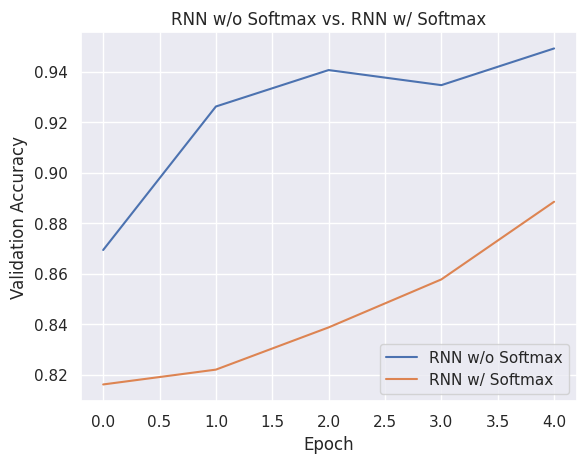

In [18]:
plt.title("RNN w/o Softmax vs. RNN w/ Softmax"); plt.xlabel("Epoch"); plt.ylabel("Validation Accuracy")
plt.plot(valid_accs_wo_softmax, label="RNN w/o Softmax")
plt.plot(valid_accs_w_softmax, label="RNN w/ Softmax")
plt.legend(loc="lower right");

### 1.4 Discussion

We can see that adding an additional Softmax layer to the RNN **slows down** training and **decrease validation performance**. This is because that the **torch.nn.CrossEntropy** is originally designed to receive raw **logits**, and it will apply softmax automatically before computing cross entropy loss according to PyTorch's documentation. Therefore, if we add an additional Softmax layer and apply nn.CrossEntropy, it essentially means that we apply Softmax **2 times**, which is not desirable for model training.

## 2. RNN v.s. CNN (4 points)
Compare the results of 2.2.1 (RNN) & 2.3.1 (CNN) in model_12_examples.ipynb.

The 1D-CNN seems to predict the time series better than the RNN. Why?

You may verify your hypotheses by computational experiments.

torch.Size([142, 1, 1]) (142,) 144


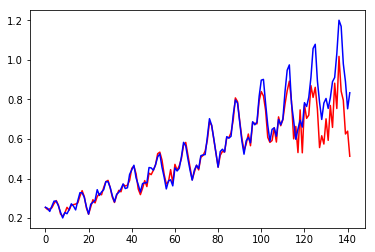

In [367]:
# 2.2.1 (RNN):

torch.Size([142, 1]) (142,) 144


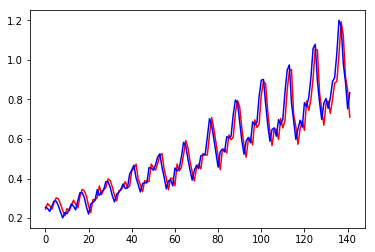

In [379]:
# 2.3.1 (CNN):

### Experiments

In [4]:
# Please run your computational experiments and write your observations accordingly.
import pandas as pd
ts = pd.read_csv('data.csv', usecols=[1]).dropna().values.astype('float32')

# Normalize:
max_value = np.max(ts)
min_value = np.min(ts)
scalar = max_value - min_value
ts = list(map(lambda x: x / scalar, ts))

# Prepare windowed data for our RNN model(s):
def create_dataset(dataset, look_back=2):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

data_X, data_Y = create_dataset(ts)

# Train-Test split:
data_X4 = np.swapaxes(data_X, 1, 2) # should be (batch, channel, input)
L = data_X4.shape[0]
train_size = int(L * 0.7) # 70% for training
test_size = L - train_size
train_X = data_X4[:train_size]
train_Y = data_Y[:train_size]
test_X = data_X4[train_size:]
test_Y = data_Y[train_size:]

train_x = t.from_numpy(train_X)
train_y = t.from_numpy(train_Y)
test_x = t.from_numpy(test_X)

print(train_x.shape,train_y.shape) # (batch,input,feature)

class cnn_reg(nn.Module):
    def __init__(self, in_channels, hidden_size, output_size, kernel_size, with_tanh: bool):
        super(cnn_reg, self).__init__()
        
        self.conv = nn.Conv1d(in_channels=in_channels, out_channels=hidden_size, kernel_size=kernel_size) # in_channels=features

        if with_tanh:
            self.reg = nn.Sequential(
                nn.Linear(hidden_size, hidden_size),
                nn.Tanh(),
                nn.Linear(hidden_size, output_size)
            )
        else:
            self.reg = nn.Linear(hidden_size, output_size) # regression
        
    def forward(self, x):
        x = self.conv(x) # (batch, channel, input)
        x = x.view(x.size()[0], -1) # flatten
        x = self.reg(x)
        return x

def train(model, criterion, optimizer):
    # Training:
    for e in range(1000):
        # Forward:
        out = model(train_x)
        loss = criterion(out, train_y)
        # Backward:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (e + 1) % 100 == 0: # print loss every 100 epochs
            print('Epoch: {}, Loss: {:.5f}'.format(e + 1, loss.data.item()))

def predict_and_visualize(net):
    # Testing on the whole series (70% trained + 30% untrained):
    net = net.eval() 
    pred_test1 = net(t.from_numpy(data_X4))
    pred_test2 = pred_test1.view(-1).data.numpy() # reshaping to a simple time series
    print(pred_test1.shape, pred_test2.shape, len(ts))

    # Visualization:
    plt.plot(pred_test2, 'r', label='prediction')
    plt.plot(ts[2:], 'b', label='real')
    plt.legend(loc="lower right")

torch.Size([99, 1, 2]) torch.Size([99, 1])


### Observation & Thoughts on the Experiments

The key observation is that the RNN model in 2.2.1 has the **hyperbolic tangent (Tanh)** activation function, while the original CNN model in 2.3.1 doesn't. Therefore, I plan to apply the **Tanh** activation in the CNN model and see if the result will be similar to the one produced by the RNN model.

### 2.1 Original CNN Model (no Tanh Actication)

Epoch: 100, Loss: 0.00378
Epoch: 200, Loss: 0.00299
Epoch: 300, Loss: 0.00265
Epoch: 400, Loss: 0.00236
Epoch: 500, Loss: 0.00214
Epoch: 600, Loss: 0.00201
Epoch: 700, Loss: 0.00194
Epoch: 800, Loss: 0.00191
Epoch: 900, Loss: 0.00190
Epoch: 1000, Loss: 0.00190
torch.Size([142, 1]) (142,) 144


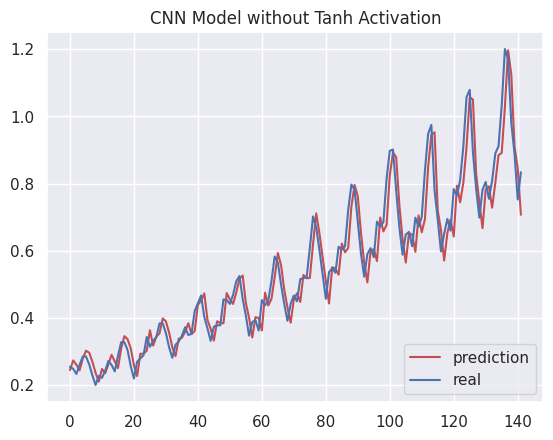

In [10]:
net = cnn_reg(in_channels=1, hidden_size=10, output_size=1, kernel_size=2, with_tanh=False)
criterion = nn.MSELoss()
optimizer = t.optim.Adam(net.parameters(), lr=1e-2)

train(net, criterion, optimizer)
plt.title("CNN Model without Tanh Activation")
predict_and_visualize(net)

### 2.2 CNN Model with Tanh Activation

Therefore I try to reduce the size of out channel to 1, and observe the results. This prevents the model from seeing the future information, so the final training loss is higher and the prediction performance is not as good as the one above.

Epoch: 100, Loss: 0.00194
Epoch: 200, Loss: 0.00186
Epoch: 300, Loss: 0.00185
Epoch: 400, Loss: 0.00185
Epoch: 500, Loss: 0.00184
Epoch: 600, Loss: 0.00184
Epoch: 700, Loss: 0.00183
Epoch: 800, Loss: 0.00182
Epoch: 900, Loss: 0.00181
Epoch: 1000, Loss: 0.00180
torch.Size([142, 1]) (142,) 144


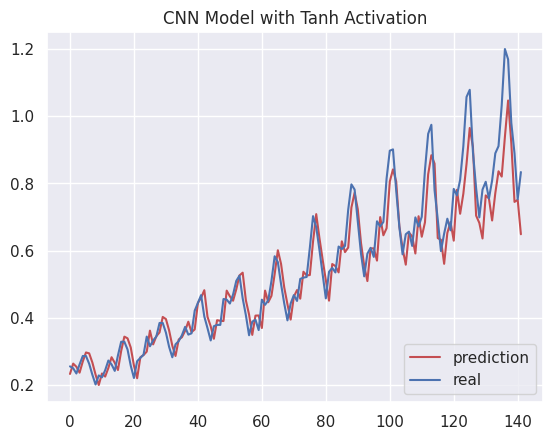

In [11]:
net = cnn_reg(in_channels=1, hidden_size=10, output_size=1, kernel_size=2, with_tanh=True)
criterion = nn.MSELoss()
optimizer = t.optim.Adam(net.parameters(), lr=1e-2)

train(net, criterion, optimizer)
plt.title("CNN Model with Tanh Activation")
predict_and_visualize(net)

### 2.3 Discussion

We can see that after applying the Tanh activation, the **result becomes more similiar** to the one **produced by the RNN model** in 2.2.1. I think part of the reason is that the **Tanh activation makes the data representation lose some original properties**, so that the Tanh converted representation cannot be properly used to forecast the future values.